In [2]:
import vitaldb
import pandas as pd
import requests
import json
import io
import time  # Importer time-modulet
import numpy as np

In [ ]:
# DENNE FUNGERER NÅ!!!!!!!!!!!!!!!!  

#Denne funksjon henter tracks ned fra en URL, og printer dem. Deretter vil en tjekke hvor mange 0
# verdier som er i trakcet. Deretter vil den gemme tracket hvis trakcet har mindre enn et hvis antall 0 verdier#

#Tracklist inneholder informationene: case identifier, track name(navnet på målingen og apparat), 
# track identifier (den konkrete patients konktere måling)
track_list_url = "https://api.vitaldb.net/trks"

#Omgjør til dataframe
df_tracklist = pd.read_csv('C:/Users/johns/Downloads/VitalDB_Tracks.csv') #Skriv tracklist_url inne i parantesen

# Opprett en liste for lagring av data som skal skrives til CSV
saved_tracks = []

#Hent hver trackidentifierverdi
for index, row in df_tracklist.iterrows():
  trackidentifier = row["tid"]
  trackdata_url = f"https://api.vitaldb.net/{trackidentifier}"
  response = requests.get(trackdata_url)
  # Konverter API-respons til en pandas DataFrame
  trackdata = pd.read_csv(io.StringIO(response.text))
  #trackdata = np.array(trackdata)
  # Se de første rækker af dataet
  print(trackdata.head())

  # Define how many rows belong to the first third
  one_third_length = len(trackdata) // 4  # Get the first third of the dataset
  # Select the first one-third of the second column
  first_third_values = trackdata.iloc[:one_third_length, 1].values

  # Count how many of those values are 0
  zero_count = np.sum(first_third_values == 0)
  # Check if all values in the first third are zero
  if zero_count == one_third_length:
    print("All values in the first third are 0")
  else:
    print(f"This track, {trackdata.columns[1]}, has {zero_count} out of {one_third_length} values in the first third are 0")
    # Lagre caseid, tname og tid
    saved_tracks.append([row["caseid"], row["tname"], row["tid"]])    

# Vent 2 sekunder før næste anmodning**
  time.sleep(2)


  # Konverter listen til en DataFrame og lagre som CSV
if saved_tracks:
    df_saved_tracks = pd.DataFrame(saved_tracks, columns=["caseid", "tname", "tid"])
    df_saved_tracks.to_csv("saved_tracks.csv", index=False)
    print("CSV file 'saved_tracks.csv' has been saved.")
else:
    print("No tracks met the criteria for saving.")





    Time  BIS/BIS
0  0.156      0.0
1  1.156      0.0
2  2.156      0.0
3  3.156      0.0
4  4.156      0.0
This track, BIS/BIS, has 151 out of 2885 values in the first third are 0
       Time  BIS/EEG1_WAV
0  0.000000         22.85
1  0.007812         22.90
2       NaN         23.05
3       NaN         23.30
4       NaN         23.70
This track, BIS/EEG1_WAV, has 123 out of 369317 values in the first third are 0
       Time  BIS/EEG2_WAV
0  0.000000         24.70
1  0.007812         25.10
2       NaN         24.75
3       NaN         24.55
4       NaN         24.35
This track, BIS/EEG2_WAV, has 110 out of 369317 values in the first third are 0
      Time  BIS/EMG
0  109.156    41.46
1  110.156    47.94
2  111.156    53.55
3  112.156    54.73
4  113.156    52.41
This track, BIS/EMG, has 0 out of 2857 values in the first third are 0
      Time  BIS/SEF
0  151.156    21.50
1  152.156    21.50
2  153.156    21.50
3  154.156    21.50
4  155.156    20.82
This track, BIS/SEF, has 0 out of 27

In [ ]:
import pandas as pd

# Hent laboratoriedata fra API
laboratory_list_url = "https://api.vitaldb.net/labs"
df_laboratory = pd.read_csv(laboratory_list_url)

#denne funksjonen henter data fra en variabel og en caseperson. Krever to inputs

def collect_laboratory_values_two_inputs(caseid, var_name):
    """
    Henter laboratorieværdier for en given patient (caseid) og en specifik laboratorievariabel (var_name).
    """
    if not isinstance(caseid, int) or not isinstance(var_name, str):
        return "Ugyldig input, vennligst bruk en integer for caseid og en string for variabelnavn"
    
    # Filtrer på både caseid og variabelnavn
    filtered_df = df_laboratory[(df_laboratory['caseid'] == caseid) & (df_laboratory['name'] == var_name)]
    
    # Hvis ingen resultater findes
    if filtered_df.empty:
        return f"Ingen data fundet for caseid {caseid} og variabel '{var_name}'"
    
    return filtered_df[['dt', 'result']]  # Returner kun tid og resultat

# Eksempel på kald
caseid_test = 2  # Erstat med en reel caseid
variable_test = "alb"  # Erstat med en reel laboratorievariabel

print(collect_laboratory_values_two_inputs(caseid_test, variable_test))

#Denne funksjonen krevet et input, enten caseid eller variabelnavn. 
# Henter enten all information ift caseif eller all information ift variabelnavn

def collect_laboratory_values(value):
    if isinstance(value, int):  # Hvis input er patient caseid
        filtered_df = df_laboratory[df_laboratory['caseid'] == value]
        data_array = filtered_df[['dt', 'name', 'result']].values
        return [['dt', 'name', 'result']] + data_array.tolist()  # Include column names

    elif isinstance(value, str):  # Hvis input er en variabelnavn
        filtered_df = df_laboratory[df_laboratory['name'] == value]
        data_array = filtered_df[['dt', 'caseid', 'result']].values
        return [['dt', 'caseid', 'result']] + data_array.tolist()  # Include column names

    else:
        return "Ugyldig input, vennligst bruk enten en integer eller en string"

# Test function
#collect_laboratory_values(1)  # Example caseid
collect_laboratory_values("alb") # Example variable name


          dt  result
114   240320     2.7
115   326060     2.7
116   152248     3.1
117   502448     3.6
118  5857898     3.6
119  5776336     4.2


[['dt', 'caseid', 'result'],
 [594470.0, 1.0, 2.9],
 [399575.0, 1.0, 3.2],
 [12614.0, 1.0, 3.4],
 [137855.0, 1.0, 3.6],
 [240320.0, 2.0, 2.7],
 [326060.0, 2.0, 2.7],
 [152248.0, 2.0, 3.1],
 [502448.0, 2.0, 3.6],
 [5857898.0, 2.0, 3.6],
 [5776336.0, 2.0, 4.2],
 [434356.0, 4.0, 2.7],
 [84859.0, 4.0, 2.8],
 [173382.0, 4.0, 2.9],
 [21562.0, 4.0, 3.0],
 [606476.0, 4.0, 3.2],
 [95134.0, 5.0, 2.4],
 [131894.0, 5.0, 2.6],
 [171210.0, 5.0, 2.6],
 [389002.0, 5.0, 2.7],
 [562562.0, 5.0, 2.7],
 [436933.0, 5.0, 2.8],
 [650249.0, 5.0, 2.8],
 [22215.0, 5.0, 2.9],
 [45619.0, 5.0, 2.9],
 [304278.0, 5.0, 2.9],
 [476006.0, 5.0, 2.9],
 [515787.0, 5.0, 2.9],
 [358258.0, 5.0, 3.0],
 [218331.0, 5.0, 3.1],
 [267064.0, 5.0, 3.1],
 [606377.0, 5.0, 3.1],
 [192033.0, 5.0, 3.2],
 [-2968.0, 5.0, 4.6],
 [-225221.0, 6.0, 3.9],
 [-97785.0, 6.0, 3.9],
 [92546.0, 6.0, 4.2],
 [215558.0, 7.0, 3.5],
 [43121.0, 7.0, 3.9],
 [129074.0, 7.0, 4.0],
 [16337.0, 7.0, 4.1],
 [-97335.0, 7.0, 4.4],
 [-77282.0, 9.0, 4.4],
 [757639.0, 

In [1]:
#HVIS MAN VIL PLOTTE ET Waveform data track. 

import numpy as np
import matplotlib.pyplot as plt

#LOADER SIGNALET  
trackdata_url = "http://api.vitaldb.net/4a15b16499ffe1761a652dde373a664289b4fa1d"
response = requests.get(trackdata_url)
trackdata = pd.read_csv(io.StringIO(response.text))
print(trackdata.head())


#Henter ut signalfrekvensen, men bruker den ikke til noe her
signal_frequency = trackdata.iloc[1, 0]

#Starttid og endetidspunkt af signalet
start_time = trackdata.iloc[0,0]
end_time = trackdata.iloc[-1,0]
num_samples = len(trackdata)


# Generér tidsakse fra start til slut med korrekt sampling-rate
#time_axis = np.arange(start_time, end_time, signal_frequency)
time_axis = np.linspace(start_time, end_time, num_samples)

# Sikrer at tidsaksen har samme længde som trackdata
time_axis = time_axis[:len(trackdata)]

plt.plot(time_axis, trackdata.iloc[:, 1]) # Plotte Time vs. måling
plt.xlabel("Tid (sekunder)")
plt.xlim(100, 120)
plt.ylabel("Måling")
plt.title(f"Tidsserie fra VitalDB: {trackdata.columns[1]}")
plt.show()

NameError: name 'requests' is not defined

        Time  Primus/PEEP_MBAR
0    352.872                 2
1    359.030                 1
2    365.286                 2
3    371.524                 3
4    377.891                 2
..       ...               ...
95   996.979                 1
96  1003.120                 1
97  1009.440                 1
98  1015.850                 1
99  1022.190                 1

[100 rows x 2 columns]


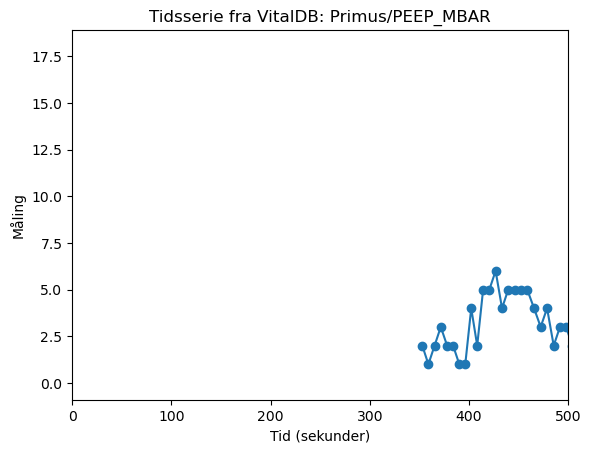

In [20]:
#HVIS MAN VIL PLOTTE ET Numeric data track. 

import numpy as np
import matplotlib.pyplot as plt

#LOADER SIGNALET  
trackdata_url = "http://api.vitaldb.net/3be29dcf1674c9dc74a57d1b6fe32ca43f08313d"
response = requests.get(trackdata_url)
trackdata = pd.read_csv(io.StringIO(response.text))
print(trackdata[0:100])


plt.plot(trackdata["Time"], trackdata.iloc[:, 1], marker='o', linestyle='-') # Plotte Time vs. måling
plt.xlabel("Tid (sekunder)")
plt.xlim(0, 500)
plt.ylabel("Måling")
plt.title(f"Tidsserie fra VitalDB: {trackdata.columns[1]}")
plt.show()